In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import tensorflow as tf
import pickle
import sys
import yaml

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, TimeDistributed, Bidirectional
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.utils import plot_model
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.models import load_model
from sklearn import preprocessing
from copy import deepcopy

import datetime
import math
import hashlib
import time
import os
from datagenerator import DataGenerator

# add
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used
# add
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 
# # sess = tf.Session(config=config) 
sess = tf.compat.v1.Session(config=config) 

Using TensorFlow backend.
/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/we

In [2]:
def loadConfig():
#     with open('/home/wesleyjtann/ddos_research/test/light_config_b.yaml', "r") as ymlfile:
    with open('./light_config_hulk.yaml', "r") as ymlfile: #GE, hulk, slowhttp, slowloris, heartbleed
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()
# artefact = 'artefact' #'artefact_b' #

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [3]:
def prepare_sentence(seq, maxlen, tokenizer):
    # Pads seq and slides windows
    seq = seq[:maxlen]
    seqX = np.append(tokenizer.word_index['<sos>'], seq)
    seqY = np.append(seq, tokenizer.word_index['<eos>'])

    x= pad_sequences([seqX],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    y= pad_sequences([seqY],
        maxlen=maxlen+1,
        padding='post')[0]  # Pads before each sequence

    return x, y

# Compute probability of occurence of a sentence
def seqPrepX(sentence, pair, model, tokenizer, histogram, datasize, maxlen) :
    #Assigns indices to each request
    tok = tokenizer.texts_to_sequences([str(sentence)])[0]

    #Prepare sentence to get input and actual output of array
    #x_test and y_test are lists of length 21.
    x_test, y_test = prepare_sentence(tok, maxlen, tokenizer)

    x_test.shape = [maxlen + 1 ,1]

    return x_test


def seqPrepY(sentence, pair, model, tokenizer, histogram, datasize, maxlen) :
    #Assigns indices to each request
    tok = tokenizer.texts_to_sequences([str(sentence)])[0]

    #Prepare sentence to get input and actual output of array
    #x_test and y_test are lists of length 21.
    x_test, y_test = prepare_sentence(tok, maxlen, tokenizer)

    return y_test

def calcProbability(maxlen, p_pred_normal, y_test)  :
    #Chain rule to calculate probability of sentence
    p_sentence = 0
    for i in range(maxlen + 1) :
        if (y_test[i] != 0) :
            # p_sentence = p_sentence + math.log(p_pred_normal[i][y_test[i]])
            p_sentence = p_sentence + math.log(p_pred_normal[i]) # add
            # p_sentence = p_sentence * p_pred_normal[i] # add

    return p_sentence

def calcHisto(pair, agent, country, histogram, agenthistogram, countryhistogram, datasize):
    #Get probability from Histogram
    p_hist = getHistogramProbability(histogram, pair, datasize)

    #Get probability from agent (Smoothed)
    agentMiniNum = agenthistogram.min()
    p_agent = getHistogramSmoothedProbability(agenthistogram, agent, datasize, agentMiniNum)

    #Get probability from country (Smoothed)
    countryMiniNum = countryhistogram.min()
    p_country = getHistogramSmoothedProbability(countryhistogram, country, datasize, countryMiniNum)

    p_hist_new = p_agent * p_country
    final_p_hist = (p_hist + p_hist_new)/2

    if final_p_hist == 0 :
        print(p_hist)
        print(p_agent)
        print(p_country)

    return math.log(final_p_hist) #final_p_hist #

# This might give the probability as 0
def getHistogramProbability(histogram, value, datasize):
    if value not in histogram :
        return 0
    else :
        return histogram[value]/datasize


# This ensures that there is at least some probability
def getHistogramSmoothedProbability(histogram, value, datasize, minimumNum):
    if value not in histogram :
        return (minimumNum/2)/datasize
    else :
        return histogram[value]/datasize
    
# add #Function to convert 3d prediction array into 2d list using real sequences
def pred2list(Pred, df_Py):
    # convert Py to 2D array
    Py = df_Py.tolist() # add
    Py = np.vstack(Py) # (9847, 121) # add
    
    # Mask all zeros
    Pred_mask = np.zeros(Pred.shape, dtype=bool)
    Pred_mask[:,:,:] = Py[:,:,np.newaxis] == 0
    field3d = np.ma.array(Pred, mask=Pred_mask)
    
    # select elements from 3d array using 2d indices
    v_shp = field3d.shape #(9847, 121, 1008)
    y,x = np.ogrid[0:v_shp[0], 0:v_shp[1]]
    field3d = field3d[y, x, Py]#.shape
    field3d = field3d.filled(0) # fill mask=True with zeros
#     field3d.shape #(9847, 121)
    field3d = field3d.tolist()
    
    return field3d

In [4]:
# #load models
modelP = load_model(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'modelP')
modelQ_online = load_model(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'modelQ_online')
modelQ_offline = load_model(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'modelQ_offline')

# load dataset
df_normal = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'N1.csv')

count = 0
df_atk_arr = []
while(True) :
    if not os.path.isfile(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_' + str(count) + '.csv') :
        break

    df_attack = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'A1_' + str(count) + '.csv')
    df_atk_arr.append(df_attack)
    count = count + 1

df_attack = pd.concat(df_atk_arr)

# load testset
df_test = pd.read_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'TEST.csv')

# loading tokenizer of normal
with open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'tokenizer_normal.pickle', 'rb') as handle:
    tokenizer_normal = pickle.load(handle)

# loading tokenizer of attack
with open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'tokenizer_attack.pickle', 'rb') as handle:
    tokenizer_attack = pickle.load(handle)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
print("length df_test: ", len(df_test)) #2541
attacker='172.16.0.1'; victim='192.168.10.50'

# True attacks
df_atk = df_test[(df_test['Source IP']==attacker) | (df_test['Source IP']==victim)]
print("length df_atk: ",  len(df_atk)) #

# True normals
# df_norm = df_test[(df_test['Source IP']!=attacker) & (df_test['Dest IP']==victim) | (df_test['Source IP']==victim)]
df_norm = df_test[~df_test.index.isin(df_atk.index)]
print("length df_norm: ",  len(df_norm))  

dftest_small = pd.concat([df_atk, df_norm])
dftest_small = dftest_small #.sample(frac=1).reset_index(drop=True)
# df_test.head()
print("length dftest_small: ", len(dftest_small)) #416

length df_test:  11710
length df_atk:  7158
length df_norm:  4552
length dftest_small:  11710


In [6]:
""" Make normal data 10% of the test data """
percentage = 0.1 #0.1{hulk, GE, heartbleed}, 0.3{slowhttp}
num_remain = (len(df_norm)/percentage)-len(dftest_small)
print(num_remain)

df_remain = df_test[~df_test.index.isin(dftest_small.index)]
df_remain = df_remain[int(len(df_remain)-num_remain):]
print("length df_remain: ", len(df_remain)) # 1270

33810.0
length df_remain:  0


In [7]:
df_test = pd.concat([dftest_small, df_remain]).sample(frac=1).reset_index(drop=True)
print("length new df_test: ", len(df_test)) #2541

length new df_test:  11710


In [8]:
maxlen=config['SEQUENCELENGTH'];modelQWithT=modelQ_online; modelQWithoutT=modelQ_offline

scoreDictionary = dict()
count = 0
df_temp = df_test[['Source IP','Dest IP', 'Input', 'Histo', 'Protocols', 'Info']].copy()

norm_size = len(df_normal)
atk_size = len(df_attack)

CountryAgentHistogram_Normal = df_normal['Histo'].value_counts()
CountryAgentHistogram_Attack = df_attack['Histo'].value_counts()

AgentHistogram_Normal = df_normal['Protocols'].value_counts()
AgentHistogram_Attack = df_attack['Protocols'].value_counts()

CountryHistogram_Normal = df_normal['Info'].value_counts()
CountryHistogram_Attack = df_attack['Info'].value_counts()


print('c1')
df_temp['Px'] = df_temp.apply(lambda x: seqPrepX(x["Input"], x["Histo"], modelP, tokenizer_normal, CountryAgentHistogram_Normal, norm_size, maxlen), axis=1)
df_temp['Py'] = df_temp.apply(lambda x: seqPrepY(x["Input"], x["Histo"], modelP, tokenizer_normal, CountryAgentHistogram_Normal, norm_size, maxlen), axis=1)

print('c2')
df_temp['Qx'] = df_temp.apply(lambda x: seqPrepX(x["Input"], x["Histo"], modelP, tokenizer_attack, CountryAgentHistogram_Attack, atk_size, maxlen),axis=1)
df_temp['Qy'] = df_temp.apply(lambda x: seqPrepY(x["Input"], x["Histo"], modelP, tokenizer_attack, CountryAgentHistogram_Attack, atk_size, maxlen),axis=1)

print("Start inference")
# start = time.time()

Pint = modelP.predict(np.array(df_temp['Px'].tolist()), batch_size=1024, verbose=1) # add 
QWithTint = modelQWithT.predict(np.array(df_temp['Qx'].tolist()), batch_size=1024, verbose=1) # add
QWithoutTint = modelQWithoutT.predict(np.array(df_temp['Qx'].tolist()), batch_size=1024, verbose=1) # add

Pint_max = pred2list(Pint, df_temp['Py']) # add
QWithTint_max = pred2list(QWithTint, df_temp['Qy']) # add
QWithoutTint_max = pred2list(QWithoutTint, df_temp['Qy']) # add
df_temp['Pint'] = Pint_max # add
df_temp['QWithTint'] = QWithTint_max # add
df_temp['QWithoutTint'] = QWithoutTint_max # add

df_temp['P_LSTM'] = df_temp.apply(lambda x: calcProbability(maxlen, x['Pint'], x['Py']),axis=1)
df_temp['hist1'] = df_temp.apply(lambda x: calcHisto(x["Histo"], x['Protocols'], x["Info"], CountryAgentHistogram_Normal, CountryHistogram_Normal, AgentHistogram_Normal, norm_size),axis=1)

df_temp['QWithT_LSTM'] = df_temp.apply(lambda x: calcProbability(maxlen, x['QWithTint'], x['Qy']),axis=1)
df_temp['hist2'] = df_temp.apply(lambda x: calcHisto(x["Histo"], x["Protocols"], x["Info"], CountryAgentHistogram_Attack, CountryHistogram_Attack, AgentHistogram_Attack, atk_size),axis=1)
df_temp['QWithoutT_LSTM'] = df_temp.apply(lambda x: calcProbability(maxlen, x['QWithoutTint'], x['Qy']),axis=1)

#     #Sorting to avoid mixing of IP and Scores
#     df_temp = df_temp.sort_values(by = ['P_LSTM'])#, ignore_index = True)
#     df_temp = df_temp.reset_index(drop=True) # add

# add #No Scaling 
df_min_max = deepcopy(df_temp[['P_LSTM','hist1', 'QWithT_LSTM', 'QWithoutT_LSTM' ,'hist2']]) #, 'QTilde']])
df_min_max['Source IP'] = df_temp['Source IP']
df_min_max['Dest IP'] = df_temp['Dest IP']
# df_min_max = deepcopy(df_temp[['Source IP','Dest IP','P_LSTM','hist1', 'QWithT_LSTM', 'QWithoutT_LSTM' ,'hist2']])

c1
c2
Start inference
11710/11710 [==============================] - 5s 431us/step


In [9]:
# Computation of scores 
df_min_max = df_min_max.rename(columns={0: 'P_LSTM', 1: 'hist1', 2: 'QWithT_LSTM', 3: 'QWithoutT_LSTM', 4: 'hist2'}) #, 5: 'QTilde'})
df_min_max['P'] = (df_min_max['P_LSTM'] + df_min_max['hist1']) #+1).apply(lambda x: math.log(x))
df_min_max['QWithT'] = (df_min_max['QWithT_LSTM'] + df_min_max['hist2']) #+1).apply(lambda x: math.log(x))
df_min_max['QWithoutT'] = (df_min_max['QWithoutT_LSTM'] + df_min_max['hist2']) #+1).apply(lambda x: math.log(x))

# add standardization
df_min_max['P'] = (df_min_max['P'] - df_min_max['P'].min(axis=0)) / (df_min_max['P'].max(axis=0) - df_min_max['P'].min(axis=0))
df_min_max['QWithT'] = (df_min_max['QWithT'] - df_min_max['QWithT'].min(axis=0)) / (df_min_max['QWithT'].max(axis=0) - df_min_max['QWithT'].min(axis=0))
df_min_max['QWithoutT'] = (df_min_max['QWithoutT'] - df_min_max['QWithoutT'].min(axis=0)) / (df_min_max['QWithoutT'].max(axis=0) - df_min_max['QWithoutT'].min(axis=0))  

df_min_max['PoverQ_online'] = df_min_max['P'] - df_min_max['QWithT'] # 
df_min_max['PoverQ_offline'] = df_min_max['P'] - df_min_max['QWithoutT'] #
    
df_min_max #[['Source IP','Dest IP','P','QWithT','QWithoutT']].sort_values(by = ['P']) #P

,P_LSTM,hist1,QWithT_LSTM,QWithoutT_LSTM,hist2,Source IP,Dest IP,P,QWithT,QWithoutT,PoverQ_online,PoverQ_offline
0,-651.721209,-6.812775,-379.302032,-331.426169,-3.642967,192.168.10.50,172.16.0.1,0.144691,0.502749,0.566411,-0.358058,-0.421720
1,-605.366939,-22.786911,-625.391347,-545.173371,-22.075855,172.16.0.1,192.168.10.50,0.184648,0.151403,0.257756,0.033245,-0.073108
2,-84.480542,-22.786911,-91.015010,-96.940488,-22.075855,192.168.10.15,151.101.44.65,0.869732,0.861177,0.853627,0.008555,0.016104
3,-626.529504,-22.786911,-592.440604,-606.321302,-22.075855,172.16.0.1,192.168.10.50,0.156814,0.195169,0.176467,-0.038355,-0.019653
4,-18.449573,-22.786911,-18.864430,-20.562129,-22.075855,192.168.10.19,172.217.12.206,0.956577,0.957009,0.955163,-0.000432,0.001414
...,...,...,...,...,...,...,...,...,...,...,...,...
11705,-4.290666,-6.604231,-4.728841,-5.065814,-5.823819,192.168.10.19,66.70.172.17,0.996483,0.997371,0.997369,-0.000887,-0.000885
11706,-23.711952,-22.786911,-22.168928,-19.198713,-22.075855,172.217.3.99,192.168.10.5,0.949656,0.952620,0.956976,-0.002964,-0.007319
11707,-619.241402,-22.786911,-548.466322,-522.398469,-22.075855,172.16.0.1,192.168.10.50,0.166400,0.253577,0.288032,-0.087177,-0.121633
11708,-599.975266,-22.786911,-438.058555,-298.315808,-22.075855,192.168.10.50,172.16.0.1,0.191739,0.400224,0.585923,-0.208485,-0.394184


In [10]:
attacker='172.16.0.1'; victim='192.168.10.50'

len(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker])
len(df_min_max['P'].sort_values()[df_min_max['Dest IP'] == victim])

3963

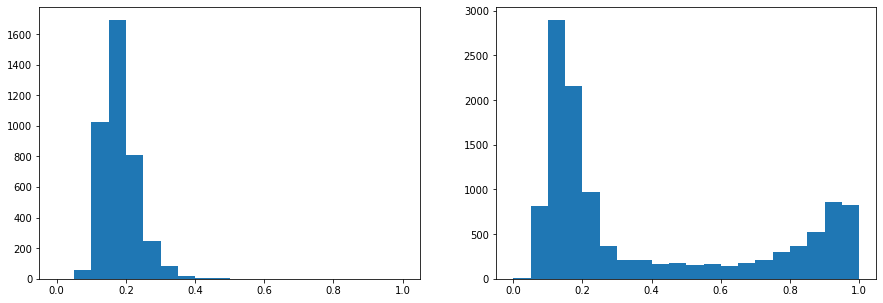

3963

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(15,5)) #plt.figure()
ax[0].hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, range=[0, 1]) #attacker:172.16.0.1, victim:192.168.10.50
ax[1].hist(df_min_max['P'].sort_values(), bins=20, range=[0, 1]) #attacker:172.16.0.1, victim:192.168.10.50
plt.show()
fig.tight_layout()
# fig.savefig('./P_values' + str(max_len) + '.png')
sum(df_min_max['Dest IP'] == '192.168.10.50')

<Figure size 432x288 with 0 Axes>

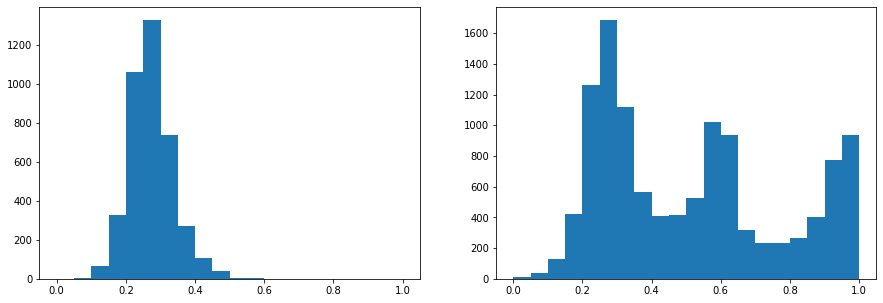

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig, ax = plt.subplots(1,2, figsize=(15,5)) #plt.figure()
ax[0].hist(df_min_max['QWithoutT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, range=[0, 1])
ax[1].hist(df_min_max['QWithoutT'].sort_values(), bins=20, range=[0, 1])
plt.show()
fig.tight_layout()
# fig.savefig('./P_values' + str(max_len) + '.png')

<Figure size 432x288 with 0 Axes>

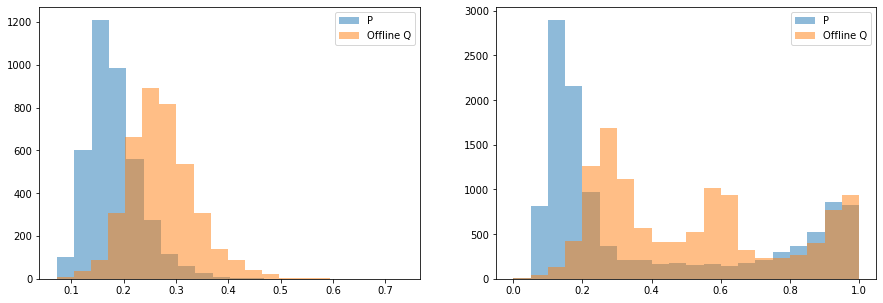

In [13]:
fig = plt.figure()
fig, ax = plt.subplots(1,2, figsize=(15,5)) #plt.figure()
# plt.hist(df_min_max['P'].sort_values()[df_min_max['Dest IP'] == victim], bins=20, alpha=0.5, label='P') #attacker:172.16.0.1, victim:192.168.10.50
# plt.hist(df_min_max['QWithoutT'].sort_values()[df_min_max['Dest IP'] == victim], bins=20, alpha=0.5, label='Offline Q')
ax[0].hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='P') #attacker:172.16.0.1, victim:192.168.10.50
ax[0].hist(df_min_max['QWithoutT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='Offline Q')
ax[1].hist(df_min_max['P'].sort_values(), bins=20, alpha=0.5, label='P') 
ax[1].hist(df_min_max['QWithoutT'].sort_values(), bins=20, alpha=0.5, label='Offline Q')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
plt.show()

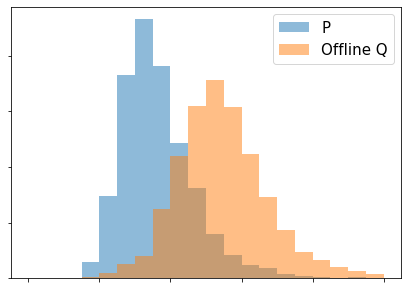

In [14]:
# fig = plt.figure(figsize=(7,5))
# plt.hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='P') #attacker:172.16.0.1, victim:192.168.10.50
# plt.hist(df_min_max['QWithoutT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='Offline Q')
# plt.legend(loc='upper right')
fig, ax = plt.subplots(1, figsize=(7,5))
ax.hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, range=[0,.5], alpha=0.5, label='P') #attacker:172.16.0.1, victim:192.168.10.50
ax.hist(df_min_max['QWithoutT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, range=[0,.5], alpha=0.5, label='Offline Q')
ax.legend(loc='upper right',prop={"size":15})
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()
# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PoverQ_offline' + '.png')

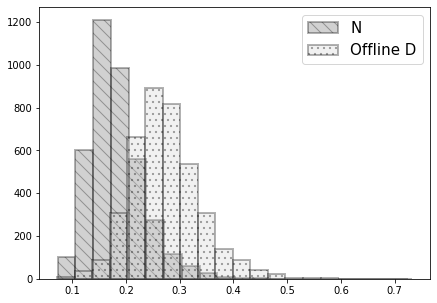

In [20]:
fig, ax = plt.subplots(1, figsize=(7,5))
ax.hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, edgecolor='black', linewidth=2, alpha=0.3, label='N', color = "dimgray", hatch=2*'\\', fill=True)
ax.hist(df_min_max['QWithoutT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, edgecolor='black', linewidth=2, alpha=0.3, label='Offline D', color = "lightgray", hatch=2*'.', fill=True)
ax.legend(loc='upper right',prop={"size":15})

plt.show()
# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PoverQ_offline' + '.png')

<Figure size 432x288 with 0 Axes>

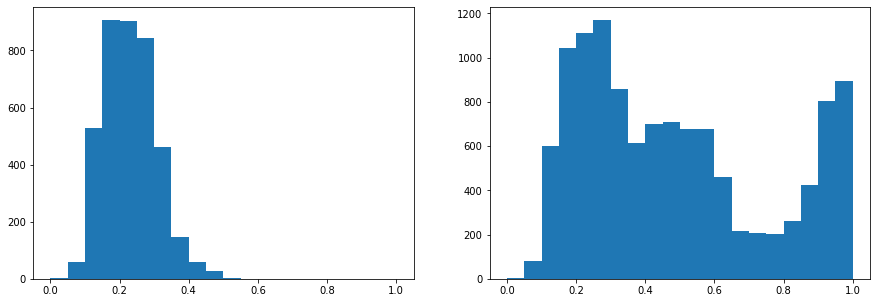

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig, ax = plt.subplots(1,2, figsize=(15,5)) #plt.figure()
ax[0].hist(df_min_max['QWithT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, range=[0, 1])
ax[1].hist(df_min_max['QWithT'].sort_values(), bins=20, range=[0, 1])
plt.show()
fig.tight_layout()
# fig.savefig('./P_values' + str(max_len) + '.png')

<Figure size 432x288 with 0 Axes>

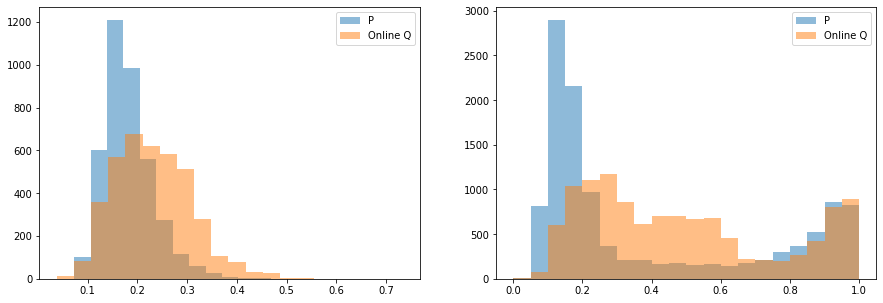

In [14]:
fig = plt.figure()
fig, ax = plt.subplots(1,2, figsize=(15,5)) #plt.figure()
# plt.hist(df_min_max['P'].sort_values()[df_min_max['Dest IP'] == victim], bins=20, alpha=0.5, label='P') #attacker:172.16.0.1, victim:192.168.10.50
# plt.hist(df_min_max['QWithT'].sort_values()[df_min_max['Dest IP'] == victim], bins=20, alpha=0.5, label='Online Q')
ax[0].hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='P') #
ax[0].hist(df_min_max['QWithT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='Online Q')
ax[1].hist(df_min_max['P'].sort_values(), bins=20, alpha=0.5, label='P') 
ax[1].hist(df_min_max['QWithT'].sort_values(), bins=20, alpha=0.5, label='Online Q')
ax[0].legend(loc='upper right')
plt.legend(loc='upper right')
plt.show()

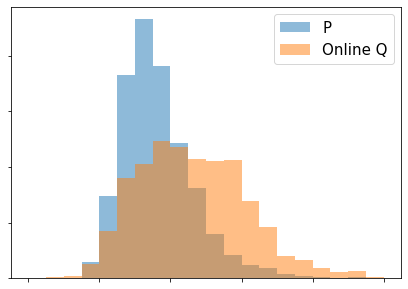

In [17]:
# fig = plt.figure(figsize=(7,5))
# plt.hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='P') #
# plt.hist(df_min_max['QWithT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, alpha=0.5, label='Online Q')
# plt.legend(loc='upper right')
fig, ax = plt.subplots(1, figsize=(7,5))
ax.hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, range=[0,.5], alpha=0.5, label='P') #
ax.hist(df_min_max['QWithT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, range=[0,.5], alpha=0.5, label='Online Q')
ax.legend(loc='upper right',prop={"size":15})
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.show()
# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PoverQ_online' + '.png')

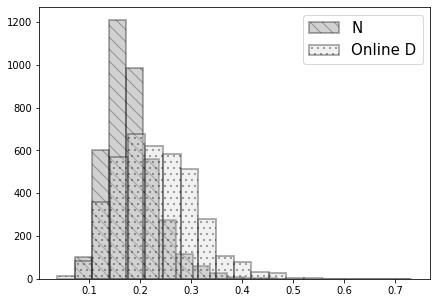

In [19]:
fig, ax = plt.subplots(1, figsize=(7,5))
ax.hist(df_min_max['P'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, edgecolor='black', linewidth=2, alpha=0.3, label='N', color = "dimgray", hatch=2*'\\', fill=True)
ax.hist(df_min_max['QWithT'].sort_values()[df_min_max['Source IP'] == attacker], bins=20, edgecolor='black', linewidth=2, alpha=0.3, label='Online D', color = "lightgray", hatch=2*'.', fill=True)
ax.legend(loc='upper right',prop={"size":15})

plt.show()
# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PoverQ_online' + '.png')

In [16]:
df_min_max['PoverQWithTransfer'] = df_min_max['P'] - df_min_max['QWithT'] #
df_min_max['PoverQWithoutTransfer'] = df_min_max['P'] - df_min_max['QWithoutT'] # 

#Sorting to avoid mixing of IP and Scores
df_min_max = df_min_max.sort_values(by = ['P']) #P
df_min_max = df_min_max.reset_index(drop=True) # add

# df_min_max[['P','QWithT','QWithoutT','PoverQWithTransfer','PoverQWithoutTransfer']]

<Figure size 432x288 with 0 Axes>

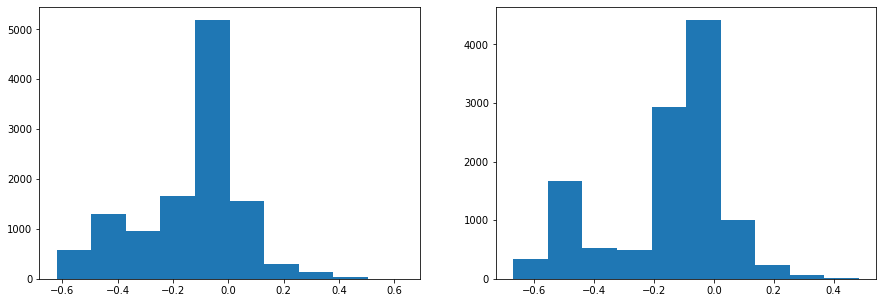

In [17]:
fig = plt.figure()
fig, ax = plt.subplots(1,2, figsize=(15,5)) #plt.figure()
ax[0].hist(df_min_max['PoverQWithTransfer'].sort_values()) #, bins=20, range=[0, 1])
ax[1].hist(df_min_max['PoverQWithoutTransfer'].sort_values()) #, bins=20, range=[0, 1])
plt.show()
fig.tight_layout()

In [18]:
sr = df_min_max[['Source IP', 'Dest IP', 'P', 'PoverQ_online','PoverQ_offline', 'QWithT', 'QWithoutT']] #, 'PoverQTilde']]
sr

,Source IP,Dest IP,P,PoverQ_online,PoverQ_offline,QWithT,QWithoutT
0,192.168.10.50,172.16.0.1,0.000000,-0.484224,-0.545972,0.484224,0.545972
1,192.168.10.50,172.16.0.1,0.000818,-0.452076,-0.466532,0.452894,0.467350
2,192.168.10.50,172.16.0.1,0.001043,-0.530212,-0.533041,0.531256,0.534084
3,192.168.10.50,172.16.0.1,0.004091,-0.371596,-0.492007,0.375687,0.496098
4,192.168.10.50,172.16.0.1,0.006250,-0.418261,-0.535104,0.424511,0.541354
...,...,...,...,...,...,...,...
11705,31.13.76.107,192.168.10.19,0.997629,-0.002371,-0.002371,1.000000,1.000000
11706,17.253.14.253,192.168.10.25,1.000000,0.006041,0.005994,0.993959,0.994006
11707,17.253.14.253,192.168.10.25,1.000000,0.006041,0.005994,0.993959,0.994006
11708,17.253.14.253,192.168.10.25,1.000000,0.006041,0.005994,0.993959,0.994006


In [19]:
sr_P = sr[['Source IP', 'Dest IP', 'P']].copy()
sr_PoverQ_online = sr[['Source IP', 'Dest IP', 'PoverQ_online']].copy()
sr_PoverQ_offline = sr[['Source IP', 'Dest IP', 'PoverQ_offline']].copy()
sr_onlineQ = sr[['Source IP', 'Dest IP', 'QWithT']].copy() # add for online Q 
sr_offlineQ = sr[['Source IP', 'Dest IP', 'QWithoutT']].copy() # add for offline Q

sr_P = sr_P.sort_values(by = ['P'])
sr_PoverQ_online = sr_PoverQ_online.sort_values(by = ['PoverQ_online'])
sr_PoverQ_offline = sr_PoverQ_offline.sort_values(by = ['PoverQ_offline'])
sr_onlineQ = sr_onlineQ.sort_values(by = ['QWithT']) # add for online Q 
sr_offlineQ = sr_offlineQ.sort_values(by = ['QWithoutT']) # add for offline Q

# #Store the data as binary data stream
sr_P.to_pickle(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PScore')

sr_PoverQ_online.to_pickle(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQonline_score') #'POverQWithTransferScore')

sr_PoverQ_offline.to_pickle(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQoffline_score') #'POverQWithoutTransferScore')

sr_onlineQ.to_pickle(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'onlineQ')
sr_offlineQ.to_pickle(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'offlineQ')

# add Save scores to csv

K.clear_session() # add
print("*****     Ending Inferencing     ******")

sess.close() # add


*****     Ending Inferencing     ******
